In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

## Step 1: Scraping and Getting the Data

In [3]:
def collect_data(subreddit, final_count):
    url = f'https://api.pushshift.io/reddit/search/submission?size=100&subreddit={subreddit}'
    data = pd.DataFrame()
    for i in range(final_count):
        print(i)
        req = requests.get(url)
        file = req.json()
        posts = file['data']
        posts_df = pd.DataFrame(posts)
        data = data.append(posts_df)
        before_param = min(posts_df['created_utc']-1)
        url = f'https://api.pushshift.io/reddit/search/submission?before={before_param}&size=100&subreddit={subreddit}'
        
    return data

In [4]:
phys_df = collect_data('physics', 50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [5]:
astro_df = collect_data('astronomy', 50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [6]:
phys_df.shape

(5000, 85)

In [7]:
astro_df.shape

(5000, 80)

In case I close my notebook I saved these files, as to avoid spending any more time on scraping.

In [8]:
phys_df.to_csv('raw_phys.csv')

In [9]:
astro_df.to_csv('raw_astro.csv')

In [141]:
np.setdiff1d(phys_df.columns, astro_df.columns) # None of these are crucial

array(['distinguished', 'gilded', 'link_flair_css_class',
       'link_flair_template_id', 'link_flair_text'], dtype=object)

## Step 2: Working with the Data

In [194]:
phys = pd.read_csv('raw_phys.csv')
phys.head(2)

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,...,is_gallery,media_metadata,distinguished,author_flair_background_color,poll_data,gilded,edited,suggested_sort,banned_by,link_flair_template_id
0,0,[],False,UFO_OVNI_ERROR_404,NaN,[],NaN,text,t2_4zzqxs61,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,MTMartino,NaN,[],NaN,text,t2_9nv3l,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
astro = pd.read_csv('raw_astro.csv')
astro.head(2)

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,...,media_metadata,author_flair_background_color,author_flair_text_color,author_cakeday,edited,banned_by,poll_data,author_flair_template_id,crosspost_parent,crosspost_parent_list
0,0,[],False,Holiday_Cheermeister,NaN,[],NaN,text,t2_4lvbx013,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,Look_on_the_upside,NaN,[],NaN,text,t2_94hepx35,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating new Datasets

In [196]:
ph_temp = pd.DataFrame(phys[['subreddit', 'title', 'selftext']])
ph_temp.head(2)

,subreddit,title,selftext
0,Physics,OVNIS ? DISPAROS ANTIAÉREOS ESPAÑOLES ? UFOs? ...,NaN
1,Physics,My musings on the universe and gravity. Fans o...,NaN


In [197]:
ast_temp = pd.DataFrame(astro[['subreddit', 'title', 'selftext']])
ast_temp.head(2)

,subreddit,title,selftext
0,Astronomy,"This was bought off a lady for my kid sister, ...",NaN
1,Astronomy,"Jupiter and one of it’s moons, Io",NaN


In [198]:
ph_temp.isnull().sum()

subreddit       0
title           0
selftext     1982
dtype: int64

In [199]:
ast_temp.isnull().sum()

subreddit       0
title           0
selftext     3488
dtype: int64

In [200]:
full_df = ph_temp.append(ast_temp)
full_df.shape

(10000, 3)

### Cleaning the Dataset

In [201]:
full_df['cleantext'] = ['' if text=='[removed]' else text for text in full_df['selftext']]

In [202]:
full_df['cleantext'] = ['' if text=='[deleted]' else text for text in full_df['cleantext']]

In [203]:
full_df['cleantext'] = full_df['cleantext'].fillna('')

### Creating and Prepping for the X feature

In [204]:
full_df['fulltext'] = full_df['title'] + full_df['cleantext']

In [205]:
full_df.head()

,subreddit,title,selftext,cleantext,fulltext
0,Physics,OVNIS ? DISPAROS ANTIAÉREOS ESPAÑOLES ? UFOs? ...,NaN,,OVNIS ? DISPAROS ANTIAÉREOS ESPAÑOLES ? UFOs? ...
1,Physics,My musings on the universe and gravity. Fans o...,NaN,,My musings on the universe and gravity. Fans o...
2,Physics,A summary of String Theory and how it can be u...,NaN,,A summary of String Theory and how it can be u...
3,Physics,A question about physics! help,[removed],,A question about physics! help
4,Physics,Student Astrophysics Society!,[removed],,Student Astrophysics Society!


In [206]:
full_df['fulltext'] = [re.sub('https?://\S+', 'url', str(fulltext)) for fulltext in full_df['fulltext']] # Aziz helped me with this

In [207]:
full_df['fulltext'] = [re.sub('\[.*?\]', '', str(fulltext)) for fulltext in full_df['fulltext']] # Aziz helped me with this


In [208]:
full_df['fulltext'] = [text.lower() for text in full_df['fulltext']]

In [209]:
full_df['lentext'] = [len(text) for text in full_df['fulltext']]

/Users/aydinyanna/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='lentext'>

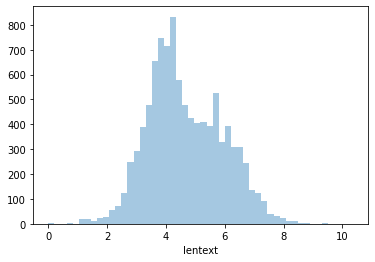

In [210]:
sns.distplot(np.log(full_df['lentext']), kde=False)

In [211]:
full_df[full_df['lentext'] < 4]

,subreddit,title,selftext,cleantext,fulltext,lentext
50,Physics,🤯🤣😂,NaN,,🤯🤣😂,3
836,Physics,Yes,[removed],,yes,3
1597,Physics,https://gf.me/u/y6rncs,[removed],,url,3
2015,Physics,X,[removed],,x,1
2854,Physics,https://youtu.be/8_wVOWJQfcU,NaN,,url,3
3591,Physics,how,NaN,,how,3
3741,Physics,https://filmi-beats.blogspot.com/2020/08/Haley...,NaN,,url,3
3797,Physics,!!,NaN,,!!,2
4059,Physics,https://www.reddit.com/user/Oneshotstudy/comme...,[removed],,url,3
4146,Physics,https://m.facebook.com/Easy-Explanations-11315...,NaN,,url,3


In [212]:
full_df = full_df[full_df['lentext'] > 3]

In [213]:
full_df.shape

(9975, 6)

In [214]:
full_df = full_df.drop(full_df.index[0])

### Creating the y feature

In [215]:
full_df['y_var'] = [1 if subreddit == 'Physics' else 0 for subreddit in full_df['subreddit']]

Baseline value: get the score above 50 percent

In [216]:
full_df['y_var'].value_counts(normalize=True)

1    0.500251
0    0.499749
Name: y_var, dtype: float64

## Step 3: Data Preprocessing

In [217]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]')

In [218]:
full_df['proctext'] = [tokenizer.tokenize(text) for text in full_df['fulltext']]

In [220]:
full_df.head()

,subreddit,title,selftext,cleantext,fulltext,lentext,y_var,proctext
1,Physics,My musings on the universe and gravity. Fans o...,NaN,,my musings on the universe and gravity. fans o...,77,1,"[my, musings, on, the, universe, and, gravity,..."
2,Physics,A summary of String Theory and how it can be u...,NaN,,a summary of string theory and how it can be u...,51,1,"[a, summary, of, string, theory, and, how, it,..."
3,Physics,A question about physics! help,[removed],,a question about physics! help,30,1,"[a, question, about, physics, help]"
4,Physics,Student Astrophysics Society!,[removed],,student astrophysics society!,29,1,"[student, astrophysics, society]"
5,Physics,Student ASTROPHYSICS Society!!!,[removed],,student astrophysics society!!!,31,1,"[student, astrophysics, society]"


In [221]:
lemmatizer = WordNetLemmatizer()

In [231]:
full_df['lemmtext'] = [[lemmatizer.lemmatize(word) for word in text] for text in full_df['proctext']]

### Create the X feature

In [233]:
full_df['x_var'] = [' '.join(words) for words in full_df['lemmtext']]

In [234]:
full_df.head()

,subreddit,title,selftext,cleantext,fulltext,lentext,y_var,proctext,lemmtext,x_var
1,Physics,My musings on the universe and gravity. Fans o...,NaN,,my musings on the universe and gravity. fans o...,77,1,"[my, musings, on, the, universe, and, gravity,...","[my, musing, on, the, universe, and, gravity, ...",my musing on the universe and gravity fan of p...
2,Physics,A summary of String Theory and how it can be u...,NaN,,a summary of string theory and how it can be u...,51,1,"[a, summary, of, string, theory, and, how, it,...","[a, summary, of, string, theory, and, how, it,...",a summary of string theory and how it can be u...
3,Physics,A question about physics! help,[removed],,a question about physics! help,30,1,"[a, question, about, physics, help]","[a, question, about, physic, help]",a question about physic help
4,Physics,Student Astrophysics Society!,[removed],,student astrophysics society!,29,1,"[student, astrophysics, society]","[student, astrophysics, society]",student astrophysics society
5,Physics,Student ASTROPHYSICS Society!!!,[removed],,student astrophysics society!!!,31,1,"[student, astrophysics, society]","[student, astrophysics, society]",student astrophysics society


## Step 4: The Final Dataset

In [236]:
final_df = full_df[['x_var', 'y_var']]
final_df.head()

,x_var,y_var
1,my musing on the universe and gravity fan of p...,1
2,a summary of string theory and how it can be u...,1
3,a question about physic help,1
4,student astrophysics society,1
5,student astrophysics society,1


## Step 5: Modelling

### Train-Test-Split

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [239]:
list(range(1000, 10000, 2000))

[1000, 3000, 5000, 7000, 9000]

In [242]:
count = 0
model_params = {}

### Model 1: CountVectorizer and MultinomialNB

In [244]:
cvec_nb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

cvec_nb_params = {
    'cvec__max_features' : range(1000, 10000, 2000),
    'cvec__min_df' : [.1, .2, .3, .4],
    'cvec__max_df' : [.96, .97, .98, .99],
    'cvec__ngram_range' : [(1,2), (2,2)]
}

cvec_nb_gs = GridSearchCV(cvec_nb_pipe, 
                  param_grid=cvec_nb_params, 
                  cv=5, 
                  n_jobs=4, 
                  verbose=1)

cvec_nb_gs.fit(X_train, y_train)

count += 1

cvec_nb_gs.best_params_['score'] = cvec_nb_gs.best_score_
model_params[f'model_{count}'] = cvec_nb_gs.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   55.4s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:   56.0s finished


In [245]:
model_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score
model_1,0.96,1000,0.1,"(1, 2)",0.552571


In [263]:
cvec_nb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

cvec_nb_params = {
    'cvec__max_features' : range(500, 2000, 500),
    'cvec__min_df' : [0, 0.1],
    'cvec__max_df' : [0.93, 0.94, 0.95, .96],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

cvec_nb_gs = GridSearchCV(cvec_nb_pipe, 
                  param_grid=cvec_nb_params, 
                  cv=5, 
                  n_jobs=4, 
                  verbose=1)

cvec_nb_gs.fit(X_train, y_train)

count += 1

cvec_nb_gs.best_params_['score'] = cvec_nb_gs.best_score_
model_params[f'model_{count}'] = cvec_nb_gs.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:   29.7s finished


In [264]:
model_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score,tf__max_df,tf__max_features,tf__min_df,tf__ngram_range,rf__ccp_alpha,rf__max_depth,rf__n_estimators
model_1,0.96,1000.0,0.1,"(1, 2)",0.552571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,0.93,1500.0,0.0,"(1, 1)",0.865286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_5,0.94,1500.0,0.0,"(1, 1)",0.856143,NaN,NaN,NaN,NaN,0.0001,NaN,100.0
model_6,0.94,2500.0,0.0,"(1, 1)",0.857571,NaN,NaN,NaN,NaN,0.0001,NaN,90.0
model_7,0.93,1500.0,0.0,"(1, 1)",0.865286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,0.552857,0.96,1000.0,0.1,"(1, 2)",NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,0.865000,0.93,1500.0,0.0,"(1, 1)",NaN,NaN,NaN


In [265]:
cvec_nb_gs.score(X_test, y_test) # For Model 1 (model 2 & 7 in the table)

0.8696666666666667

### Model 2: TF-IDFVectorizer and PolynomialNB

In [252]:
tf_nb_pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

tf_nb_params = {
    'tf__max_features' : range(1000, 10000, 2000),
    'tf__min_df' : [.1, .2, .3, .4],
    'tf__max_df' : [.96, .97, .98, .99],
    'tf__ngram_range' : [(1,2), (2,2)]
}

tf_nb_gs = GridSearchCV(tf_nb_pipe, 
                  param_grid=tf_nb_params, 
                  cv=5, 
                  n_jobs=4, 
                  verbose=1)

tf_nb_gs.fit(X_train, y_train)

count += 1

tf_nb_gs.best_params_['score'] = tf_nb_gs.best_score_
model_params[f'model_{count}'] = tf_nb_gs.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   52.4s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:   52.8s finished


In [253]:
model_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score,tf__max_df,tf__max_features,tf__min_df,tf__ngram_range
model_1,0.96,1000.0,0.1,"(1, 2)",0.552571,NaN,NaN,NaN,NaN
model_2,0.93,1500.0,0.0,"(1, 1)",0.865286,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,0.552857,0.96,1000.0,0.1,"(1, 2)"


In [254]:
tf_nb_pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

tf_nb_params = {
    'tf__max_features' : range(500, 2000, 500),
    'tf__min_df' : [0, 0.1],
    'tf__max_df' : [0.93, 0.94, 0.95, .96],
    'tf__ngram_range' : [(1,1), (1,2)]
}

tf_nb_gs = GridSearchCV(tf_nb_pipe, 
                  param_grid=tf_nb_params, 
                  cv=5, 
                  n_jobs=4, 
                  verbose=1)

tf_nb_gs.fit(X_train, y_train)

count += 1

tf_nb_gs.best_params_['score'] = tf_nb_gs.best_score_
model_params[f'model_{count}'] = tf_nb_gs.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:   15.8s finished


In [270]:
tf_nb_gs.score(X_test, y_test) # The score for the test model 2

0.875

In [267]:
model_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score,tf__max_df,tf__max_features,tf__min_df,tf__ngram_range,rf__ccp_alpha,rf__max_depth,rf__n_estimators
model_1,0.96,1000.0,0.1,"(1, 2)",0.552571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,0.93,1500.0,0.0,"(1, 1)",0.865286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_5,0.94,1500.0,0.0,"(1, 1)",0.856143,NaN,NaN,NaN,NaN,0.0001,NaN,100.0
model_6,0.94,2500.0,0.0,"(1, 1)",0.857571,NaN,NaN,NaN,NaN,0.0001,NaN,90.0
model_7,0.93,1500.0,0.0,"(1, 1)",0.865286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_3,NaN,NaN,NaN,NaN,0.552857,0.96,1000.0,0.1,"(1, 2)",NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,0.865000,0.93,1500.0,0.0,"(1, 1)",NaN,NaN,NaN


### Model 3: CountVectorizer and RandomForest

In [258]:
cvec_rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

cvec_rf_params = {
    'cvec__max_features' : range(500, 2000, 500),
    'cvec__min_df' : [0, 0.1],
    'cvec__max_df' : [0.93, 0.94],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'rf__n_estimators' : [50, 75, 100],
    'rf__max_depth': [None, 4, 5],
    'rf__ccp_alpha' : [0, 0.0001, 0.001, 0.01]
}

cvec_rf_gs = GridSearchCV(cvec_rf_pipe, 
                  param_grid=cvec_rf_params, 
                  cv=5, 
                  n_jobs=4, 
                  verbose=1)

cvec_rf_gs.fit(X_train, y_train)

count += 1

cvec_rf_gs.best_params_['score'] = cvec_rf_gs.best_score_
model_params[f'model_{count}'] = cvec_rf_gs.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  9.3min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 12.2min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 15.6min
[Parallel(n_jobs=4)]: Done 4320 out of 4320 | elapsed: 16.5min finished


In [259]:
model_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score,tf__max_df,tf__max_features,tf__min_df,tf__ngram_range,rf__ccp_alpha,rf__max_depth,rf__n_estimators
model_1,0.96,1000.0,0.1,"(1, 2)",0.552571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,0.93,1500.0,0.0,"(1, 1)",0.865286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_5,0.94,1500.0,0.0,"(1, 1)",0.856143,NaN,NaN,NaN,NaN,0.0001,NaN,100.0
model_3,NaN,NaN,NaN,NaN,0.552857,0.96,1000.0,0.1,"(1, 2)",NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,0.865000,0.93,1500.0,0.0,"(1, 1)",NaN,NaN,NaN


In [260]:
cvec_rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

cvec_rf_params = {
    'cvec__max_features' : range(1000, 3000, 500),
    'cvec__min_df' : [0, 0.01, 0.02, 0.03],
    'cvec__max_df' : [0.94, 0.95, 0.96],
    'cvec__ngram_range' : [(1,1), (2,2)],
    'rf__n_estimators' : [90, 100, 110],
    'rf__max_depth': [None],
    'rf__ccp_alpha' : [0.00001, 0.0001]
}

cvec_rf_gs = GridSearchCV(cvec_rf_pipe, 
                  param_grid=cvec_rf_params, 
                  cv=5, 
                  n_jobs=4, 
                  verbose=1)

cvec_rf_gs.fit(X_train, y_train)

count += 1

cvec_rf_gs.best_params_['score'] = cvec_rf_gs.best_score_
model_params[f'model_{count}'] = cvec_rf_gs.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 10.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 15.3min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 20.7min
[Parallel(n_jobs=4)]: Done 2880 out of 2880 | elapsed: 24.7min finished


In [261]:
model_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score,tf__max_df,tf__max_features,tf__min_df,tf__ngram_range,rf__ccp_alpha,rf__max_depth,rf__n_estimators
model_1,0.96,1000.0,0.1,"(1, 2)",0.552571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_2,0.93,1500.0,0.0,"(1, 1)",0.865286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_5,0.94,1500.0,0.0,"(1, 1)",0.856143,NaN,NaN,NaN,NaN,0.0001,NaN,100.0
model_6,0.94,2500.0,0.0,"(1, 1)",0.857571,NaN,NaN,NaN,NaN,0.0001,NaN,90.0
model_3,NaN,NaN,NaN,NaN,0.552857,0.96,1000.0,0.1,"(1, 2)",NaN,NaN,NaN
model_4,NaN,NaN,NaN,NaN,0.865000,0.93,1500.0,0.0,"(1, 1)",NaN,NaN,NaN


In [269]:
cvec_rf_gs.score(X_test, y_test)

0.862

### All Scores

In [285]:
scores = pd.DataFrame()

In [286]:
scores['models'] = ['cvec_nb', 'tfidf_nb', 'cvec_rf']

In [288]:
scores['train_acc_score'] = [cvec_nb_gs.score(X_train, y_train), tf_nb_gs.score(X_train, y_train), cvec_rf_gs.score(X_train, y_train)]

In [292]:
scores['test_acc_score'] = [cvec_nb_gs.score(X_test, y_test), tf_nb_gs.score(X_test, y_test), cvec_rf_gs.score(X_test, y_test)]

In [293]:
scores

,models,train_score,test_acc_score
0,cvec_nb,0.887143,0.869667
1,tfidf_nb,0.888571,0.875000
2,cvec_rf,0.970143,0.862000


From the model we can see that the Random Forest model is severely overfit.
The best result comes from the TF-IDF and Polynomial Naivë Bayes model which I will use to evaluate and explain

## Step 6: Evaluation and Explanation

### Where predictions are not the same as reality

In [296]:
y_preds = tf_nb_gs.predict(X_test)

In [308]:
y_preds

array([1, 0, 0, ..., 1, 1, 1])

In [311]:
y_test

44    1
78    0
84    0
39    1
15    1
     ..
10    0
18    0
65    0
54    1
74    0
Name: y_var, Length: 3000, dtype: int64

In [302]:
X_test

44    suppose you want to make 1000 random points to...
78    cool picture i have taken by my iphone 11 and ...
84                 here's the moon from my telescope :)
39    what insights into gravity *theory* have been ...
15                       genuinely stumped on this one.
                            ...                        
10    i photographed the blue horse head nebula. the...
18                                                hello
65    can someone help me identify this please (info...
54               i'm definitely going to pursue physics
74                                  flowers and nebulas
Name: title, Length: 3000, dtype: object

In [303]:
pred_df = pd.DataFrame()

In [306]:
pred_df['real_value'] = y_test

In [309]:
pred_df['predicted'] = y_preds

In [320]:
pred_df['text'] = X_test

In [321]:
pred_df.head()

,real_value,predicted,text
44,1,1,suppose you want to make 1000 random points to...
78,0,0,cool picture i have taken by my iphone 11 and ...
84,0,0,here's the moon from my telescope :)
39,1,1,what insights into gravity *theory* have been ...
15,1,0,genuinely stumped on this one.


In [345]:
wrong_data = pred_df[pred_df['real_value'] != pred_df['predicted']]

In [323]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [326]:
fp + fn # I did this to make sure that I grabbed the proper part of the data from pred_df

375

In [352]:
tn + tp

2625

#### Let's see what words are misclassified

In [328]:
cvec = CountVectorizer(stop_words='english')

In [330]:
cvec.fit(X_train)
transf_X_test = cvec.transform(X_test)

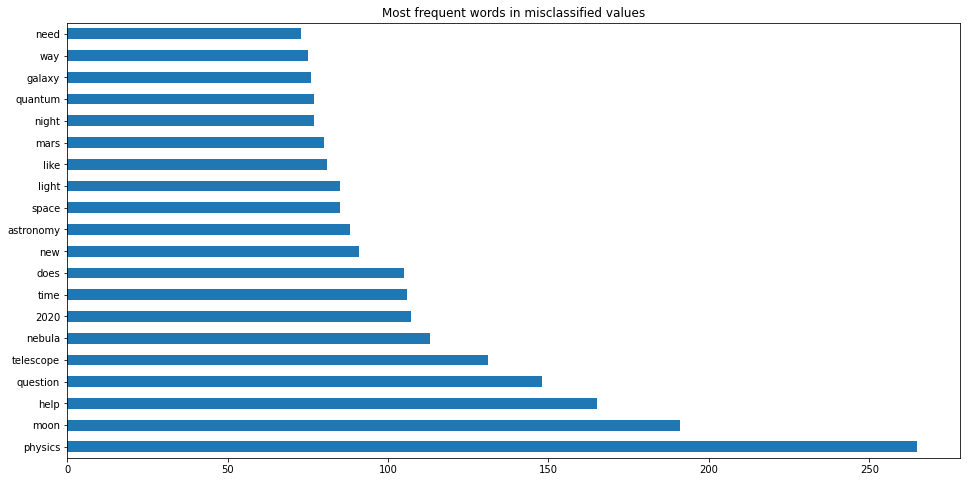

In [354]:
plt.figure(figsize=(16, 8))
transf_df = pd.DataFrame(transf_X_test.todense(),
                        columns = cvec.get_feature_names())

transf_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Most frequent words in misclassified values');

In [346]:
for i in range(len(wrong_data['text'])):
    if 'physics' in wrong_data['text'].iloc[i]:
        print(wrong_data.iloc[i])

real_value                                                    0
predicted                                                     1
text          how hard is it to get a job in astronomy/ astr...
Name: 84, dtype: object
real_value                                                    1
predicted                                                     0
text          not sure if it fits but i wanted to share a pi...
Name: 90, dtype: object
real_value                                    0
predicted                                     1
text          astronomy major vs. physics major
Name: 3, dtype: object
real_value                                                    0
predicted                                                     1
text          the influence of the electric polarization of ...
Name: 47, dtype: object
real_value                                                    0
predicted                                                     1
text          in case you missed it, any university with 

"(source: eht collaboration) m87's wobbling shadow over five years, in anticipation of an upcoming paper, to be published on september 23rd, 2020."

In [348]:
for i in range(len(wrong_data['text'])):
    if 'astronomy' in wrong_data['text'].iloc[i]:
        print(wrong_data.iloc[i])

real_value                                                    0
predicted                                                     1
text          please help me with my astronomy assignment i ...
Name: 50, dtype: object
real_value                                                    0
predicted                                                     1
text          please recommend me books or works to study an...
Name: 50, dtype: object
real_value                                                    0
predicted                                                     1
text          anyone here who might be interested in writing...
Name: 74, dtype: object
real_value                                                    0
predicted                                                     1
text          how hard is it to get a job in astronomy/ astr...
Name: 84, dtype: object
real_value                                    0
predicted                                     1
text          careers in the field of as

In [347]:
for i in range(len(wrong_data['text'])):
    if 'galaxy' in wrong_data['text'].iloc[i]:
        print(wrong_data.iloc[i])

real_value                                                    0
predicted                                                     1
text          in a galaxy made of anti-matter, a supernova w...
Name: 31, dtype: object
real_value                                                    1
predicted                                                     0
text          if we can't really tell tell if there is a pla...
Name: 23, dtype: object
real_value                                                    0
predicted                                                     1
text          in a galaxy made of anti-matter, a supernova w...
Name: 30, dtype: object
real_value                                                    1
predicted                                                     0
text          if the light from stars take thousands of year...
Name: 29, dtype: object
real_value                                                    1
predicted                                                     0
text    

In [349]:
for i in range(len(wrong_data['text'])):
    if 'quantum' in wrong_data['text'].iloc[i]:
        print(wrong_data.iloc[i])

real_value                                                    0
predicted                                                     1
text          how small a black hole can get? quantum mechan...
Name: 61, dtype: object


In [350]:
for i in range(len(wrong_data['text'])):
    if 'mars' in wrong_data['text'].iloc[i]:
        print(wrong_data.iloc[i])

real_value                                                    0
predicted                                                     1
text          water on mars: discovery of three buried lakes...
Name: 63, dtype: object
real_value                                                    1
predicted                                                     0
text          scientists have designed a way to transform wa...
Name: 1, dtype: object
real_value                           1
predicted                            0
text          what is the mass of mars
Name: 65, dtype: object
real_value                                                    1
predicted                                                     0
text          is being john malkovich real? like, could some...
Name: 56, dtype: object


In [353]:
for i in range(len(wrong_data['text'])):
    if 'moon' in wrong_data['text'].iloc[i]:
        print(wrong_data.iloc[i])

real_value                                                    1
predicted                                                     0
text          is the moon in the gravitational field of the ...
Name: 91, dtype: object
real_value                                                    0
predicted                                                     1
text          can the moon be upside down? which way up does...
Name: 47, dtype: object
real_value                                         0
predicted                                          1
text          i can stair at this forever. moonlight
Name: 76, dtype: object
real_value                                                    1
predicted                                                     0
text          how many helium balloons would it take to lift...
Name: 53, dtype: object
